# Trabajo Final de Análisis Estadístico

Maestría en Ciencia de Datos (UNAJ)

Facundo Cuba  
Leticia Nanini  
Mauro Cejas Marcovecchio  
Yesica Travasso  
July 3, 2025

In [ ]:
knitr::opts_chunk$set(
    echo = TRUE,
    message = FALSE,
    warning = FALSE
)

library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Loading required package: zoo


Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: survival

## Descripción

El objetivo del siguiente trabajo es el procesamiento de datos y análisis estadísticos del dataset provisto por el Sistema de Información y Gestión Agrometeorológica (SIGA), del [Instituto Nacional de Tecnología Agropecuaria (INTA)](https://siga.inta.gob.ar/). Esta base de datos contiene información agrometeorológica de la ciudad de Castelar, Provincia de Buenos Aires, Argentina.

## 1. Estadística descriptiva

En primer lugar, vamos a poder tener una primera aproximación a los datos a partir del paquete ReadR, ya que el delimitador utilizado para separar las columnas es “;” y “.” como separador decimal.

In [ ]:
# Cargamos los datos del grupo

archivo <- "datos/01_Buenos_Aires_Castelar.csv"

df <- read_delim(archivo, 
                 delim = ";", 
                 locale = locale(decimal_mark = "."))

Rows: 472 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ";"
dbl  (4): Temperatura_Abrigo_150cm, Humedad_Media, Presion_Media, Radiacion_...
dttm (1): Fecha

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Así, podremos ver que tendremos 472 observaciones con 5 variables:

-   **Fecha**(en formato fecha): Día de medición.

-   **Temperatura_Abrigo_150cm** (en formato número): La temperatura de abrigo es aquella medida en el abrigo meteorológico, que protege los instrumentos de medición de la radiación directa del sol, de la radiación terrestre nocturna, precipitación y condensación, entre otros. Su piso de abrigo es la altura a la que es medida la temperatura. En este caso, es de 150 cm por sobre el nivel del suelo.

-   **Humedad Media** (en formato número): La humedad relativa es la relación entre la presión parcial del vapor de agua y la presión de vapor de equilibrio del agua a una temperatura dada.

-   **Presión Media** (en formato número): La presión atmosférica es la fuerza por unidad de superficie que ejerce el aire que forma la atmósfera sobre la superficie terrestre.

-   **Radiación Global** (en formato número): La radiación global es la radiación solar que recibe la superficie terrestre

In [ ]:
head(df)

# A tibble: 6 × 5
  Fecha               Temperatura_Abrigo_150cm Humedad_Media Presion_Media
  <dttm>                                 <dbl>         <dbl>         <dbl>
1 2023-08-10 00:00:00                    14.9             94         1009.
2 2023-08-11 00:00:00                    13.4             59         1014.
3 2023-08-12 00:00:00                     7.99            51         1025.
4 2023-08-13 00:00:00                     7.24            58         1022.
5 2023-08-14 00:00:00                    14.6             48         1015.
6 2023-08-15 00:00:00                    18.3             56         1010.
# ℹ 1 more variable: Radiacion_Global <dbl>

También, podremos realizar una descripción numérica de los datos a partir de sus principales medidas de estadística descriptiva:

In [ ]:
estadisticas <- df |>
  select(-Fecha) |>
  summarise(across(everything(), 
                  list(Minimo = min,
                       Q1 = ~quantile(., 0.25),
                       Mediana = median,
                       Media = mean, 
                       Q3 = ~quantile(., 0.75),
                       Maximo = max,
                       Desvio = sd,
                       IQR = IQR),
                  .names = "{.col}-{.fn}")) |>
  pivot_longer(everything(), 
               names_to = c("Variable", "Estadistica"), 
               names_sep = "-") |>
  pivot_wider(names_from = "Variable", values_from = "value")

estadisticas |>
  gt(rowname_col = "Estadistica",
     groupname_col = "")|>
  
  tab_stubhead(label = "Medidas") |>
  fmt_number(decimals = 2) |>
  
  cols_label(
    "Temperatura_Abrigo_150cm" = "Temperatura",
    "Humedad_Media" = "Humedad",
    "Presion_Media" = "Presion",
    "Radiacion_Global" = "Radiación"
  ) |>
  
  tab_style(
    style = cell_text(color = "black", 
                        weight = "bold"),
   locations = list(
        cells_stub(),
        cells_stubhead(),
        cells_column_labels(everything())))

Tales medidas podrán ser visualizadas de mejor manera a partir de gráficos de líneas tradicionales, suavizados, histogramas y box-plots.

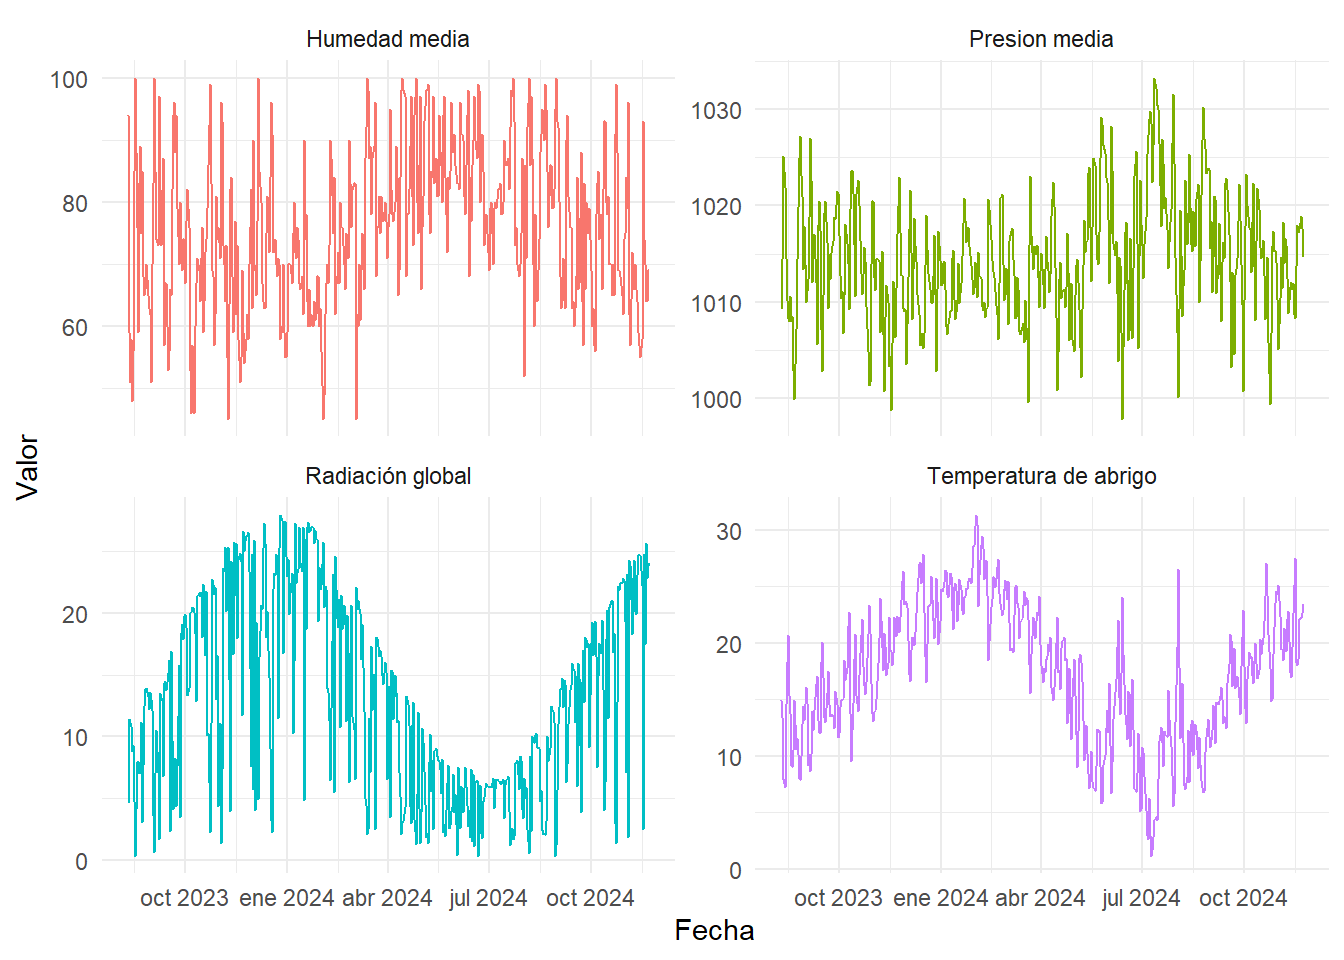

In [ ]:
df_long <- df |>
  pivot_longer(cols = -Fecha, names_to = "Variable", values_to = "Valor")

ggplot(df_long, aes(x = Fecha, y = Valor, color = Variable)) +
  geom_line(show.legend = FALSE) +
  facet_wrap(~Variable, 
             scales = "free_y",
             labeller = labeller(
               Variable = c(
                 "Humedad_Media" = "Humedad media",
                 "Presion_Media" = "Presion media",
                 "Radiacion_Global" = "Radiación global",
                 "Temperatura_Abrigo_150cm" = "Temperatura de abrigo"))) +
  theme_minimal()

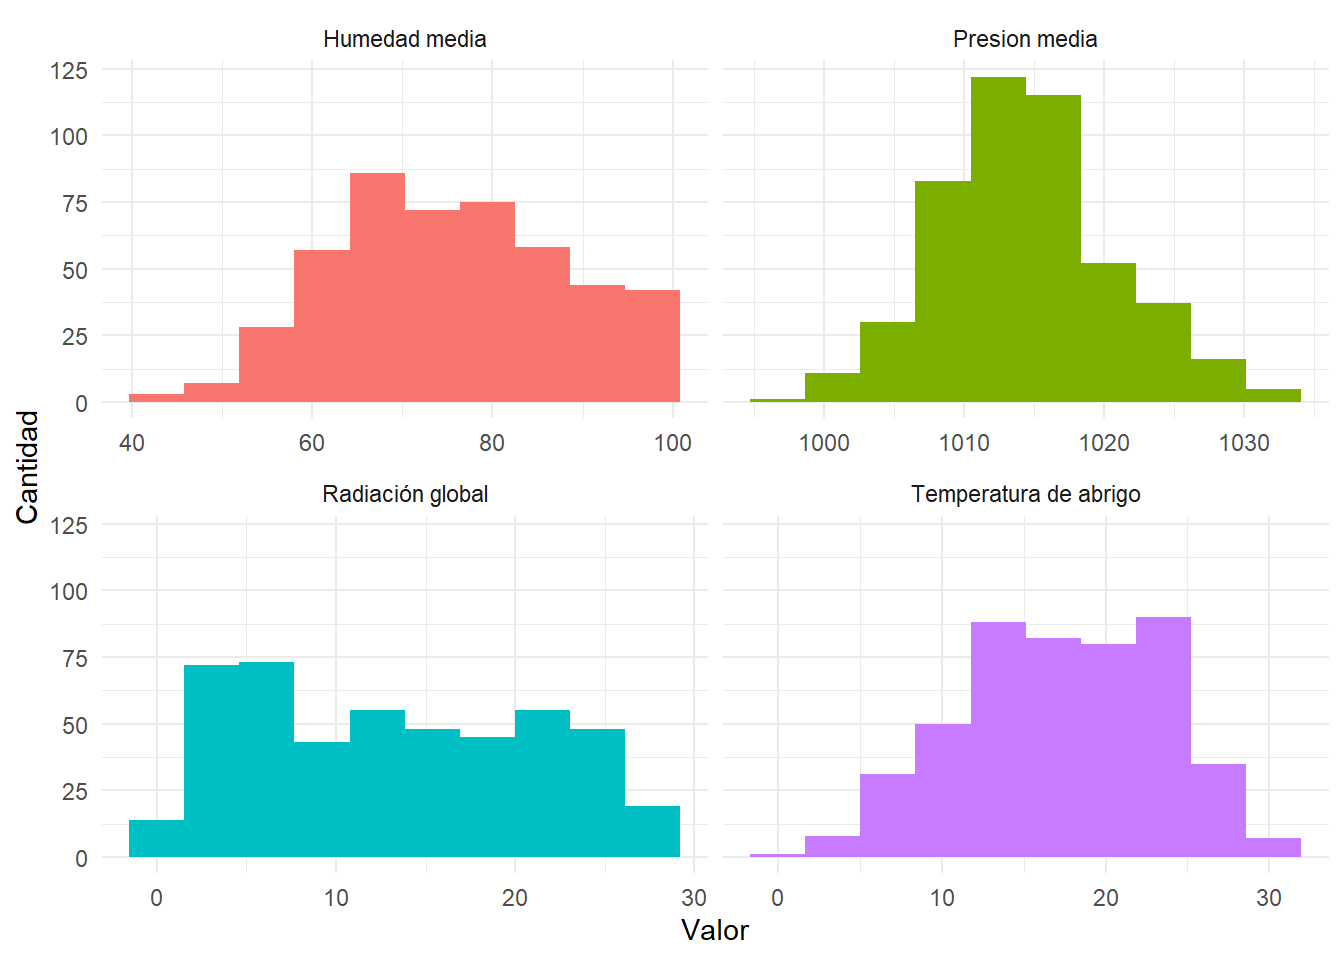

In [ ]:
ggplot(df_long, aes(x = Valor, fill = Variable)) +
  geom_histogram(bins = 10, show.legend = FALSE) +
  facet_wrap(~Variable, 
             scales = "free_x",
             labeller = labeller(
               Variable = c(
                 "Humedad_Media" = "Humedad media",
                 "Presion_Media" = "Presion media",
                 "Radiacion_Global" = "Radiación global",
                 "Temperatura_Abrigo_150cm" = "Temperatura de abrigo"))) +
  theme_minimal() +
  labs(y = "Cantidad")

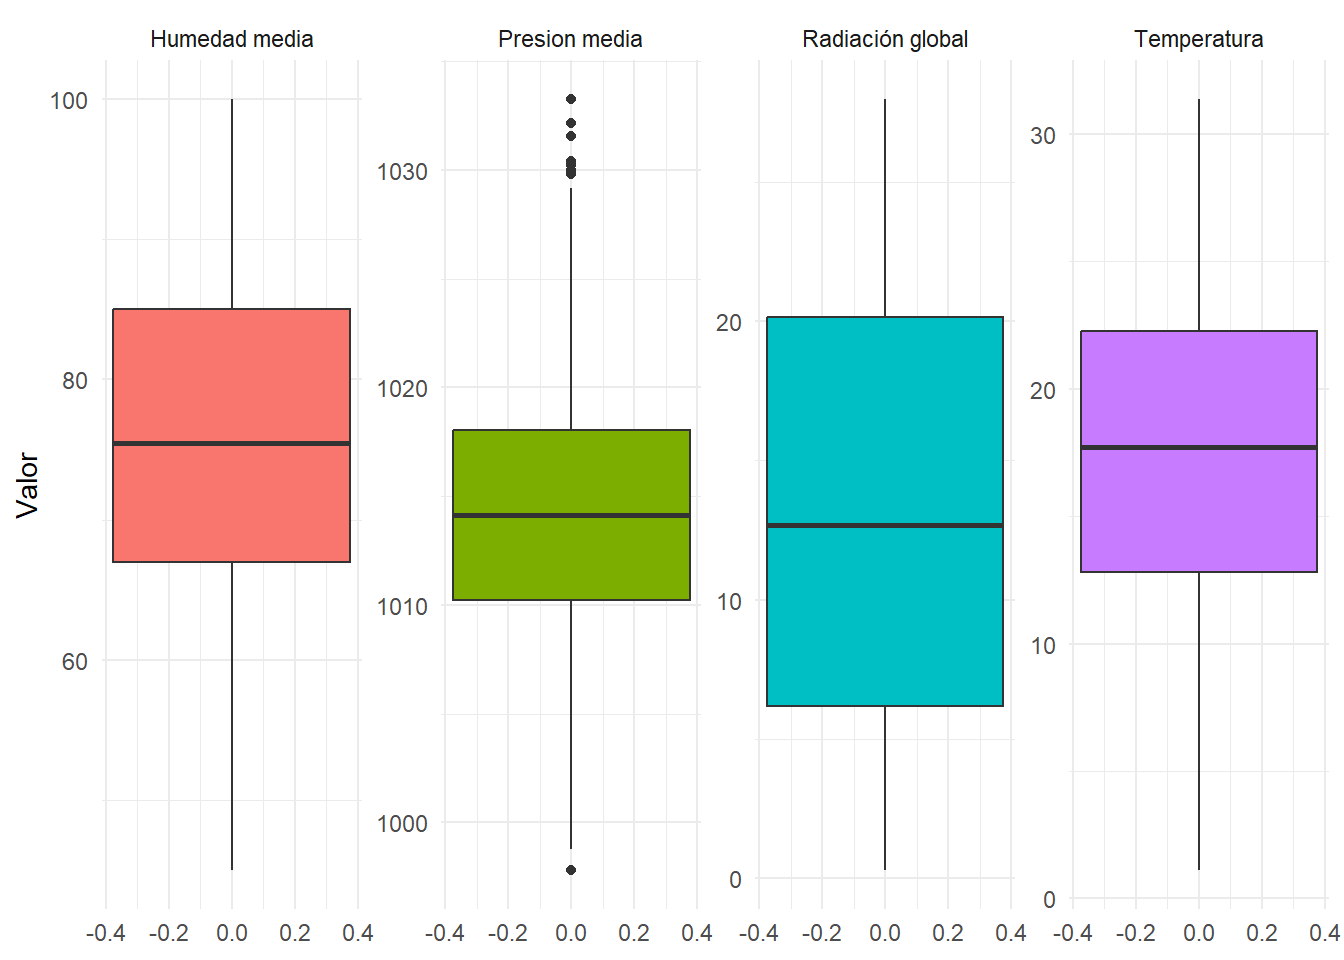

In [ ]:
ggplot(df_long, aes(y = Valor, fill = Variable)) +
  geom_boxplot(show.legend = FALSE) +
  facet_wrap(~Variable, 
             scales = "free_y", 
             nrow = 1,
             labeller = labeller(
               Variable = c(
                 "Humedad_Media" = "Humedad media",
                 "Presion_Media" = "Presion media",
                 "Radiacion_Global" = "Radiación global",
                 "Temperatura_Abrigo_150cm" = "Temperatura"))) +
  theme_minimal() +
  labs(y = "Valor")

## 2. Test de Hipótesis - Regresión Lineal

Con el fin de tener una primera imagen acerca de las relaciones entre pares de las variables vamos a realizar una matriz de dispersión.

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter
Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter

Warning in plot.xy(xy.coords(x, y), type = type, ...): "rowlattop" is not a
graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter

Warning in plot.xy(xy.coords(x, y), type = type, ...): "rowlattop" is not a
graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy.coords(x, y), type = type, ...): "rowlattop" is not a
graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter
Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter

Warning in plot.xy(xy.coords(x, y), type = type, ...): "rowlattop" is not a
graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter

Warning in plot.xy(xy.coords(x, y), type = type, ...): "rowlattop" is not a
graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter

Warning in plot.xy(xy.coords(x, y), type = type, ...): "rowlattop" is not a
graphical parameter

Warning in plot.window(...): "rowlattop" is not a graphical parameter

Warning in plot.xy(xy, type, ...): "rowlattop" is not a graphical parameter

Warning in title(...): "rowlattop" is not a graphical parameter

Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter
Warning in axis(side = side, at = at, labels = labels, ...): "rowlattop" is not
a graphical parameter

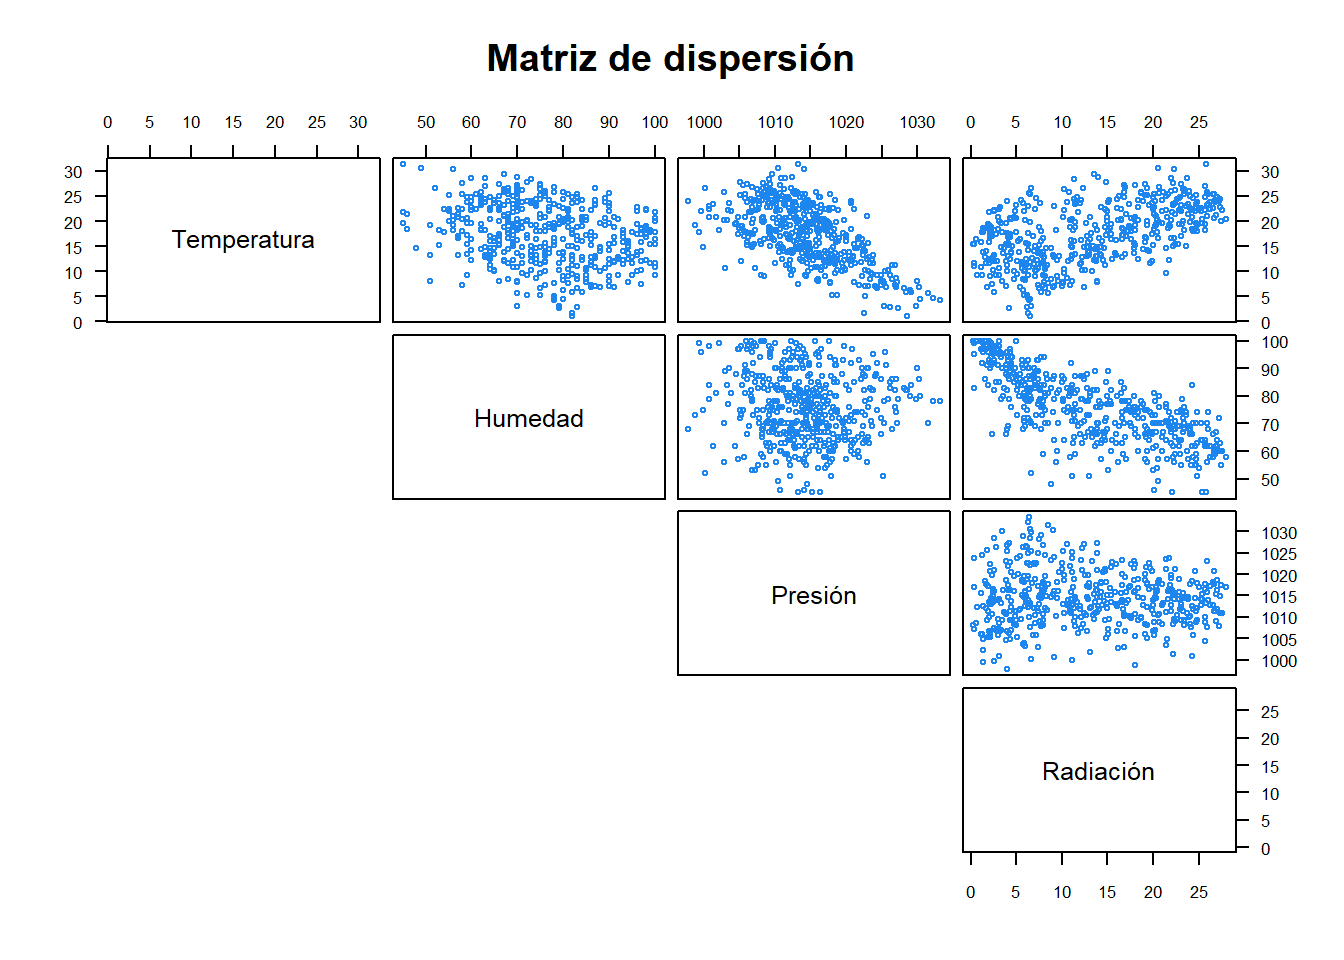

In [ ]:
df |>
  select(-Fecha) |>
  pairs(lower.panel = NULL,
        pch = 1,
        col = 'dodgerblue2',
        main = "Matriz de dispersión",
        las = 1,
        labels = c("Temperatura", "Humedad", "Presión", "Radiación"),
        gap = 0.5,
        rowlattop = FALSE,
        cex = 0.6,
        cex.labels = 1.2,
        cex.axis = 0.8,
        font.labels = 1)

Al ver el diagrama de dispersión entre los valores de temperatura de abrigo y la radiación global, podríamos inferir una correlación positiva entre ambas. Por tal motivo, vamos a realizar un modelo de regresión lineal simple para comprobarlo, en el que la Temperatura de Abrigo dependa del nivel de Radiación Global.

In [ ]:
modelo_regresion <- lm(Temperatura_Abrigo_150cm ~ Radiacion_Global, data = df)

summary(modelo_regresion)


Call:
lm(formula = Temperatura_Abrigo_150cm ~ Radiacion_Global, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3965  -3.4291  -0.2018   3.6603  12.0112 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      11.81568    0.45364   26.05   <2e-16 ***
Radiacion_Global  0.41605    0.02961   14.05   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.067 on 470 degrees of freedom
Multiple R-squared:  0.2958,    Adjusted R-squared:  0.2943 
F-statistic: 197.5 on 1 and 470 DF,  p-value: < 2.2e-16

A partir del resumen, podremos ver que los coeficientes del modelo serán una ordenada al origen de 11.81 y una pendiente de 0.41. Asimismo, graficaremos la regresión junto al cálculo de sus intervalos de confianza con un nivel del 95% (siendo notable la cantidad de observaciones que se encuentren por fuera de sus valores):

In [ ]:
print("Intervalos de confianza para los coeficientes:")

[1] "Intervalos de confianza para los coeficientes:"

                      2.5 %    97.5 %
(Intercept)      10.9242703 12.707081
Radiacion_Global  0.3578743  0.474234

`geom_smooth()` using formula = 'y ~ x'

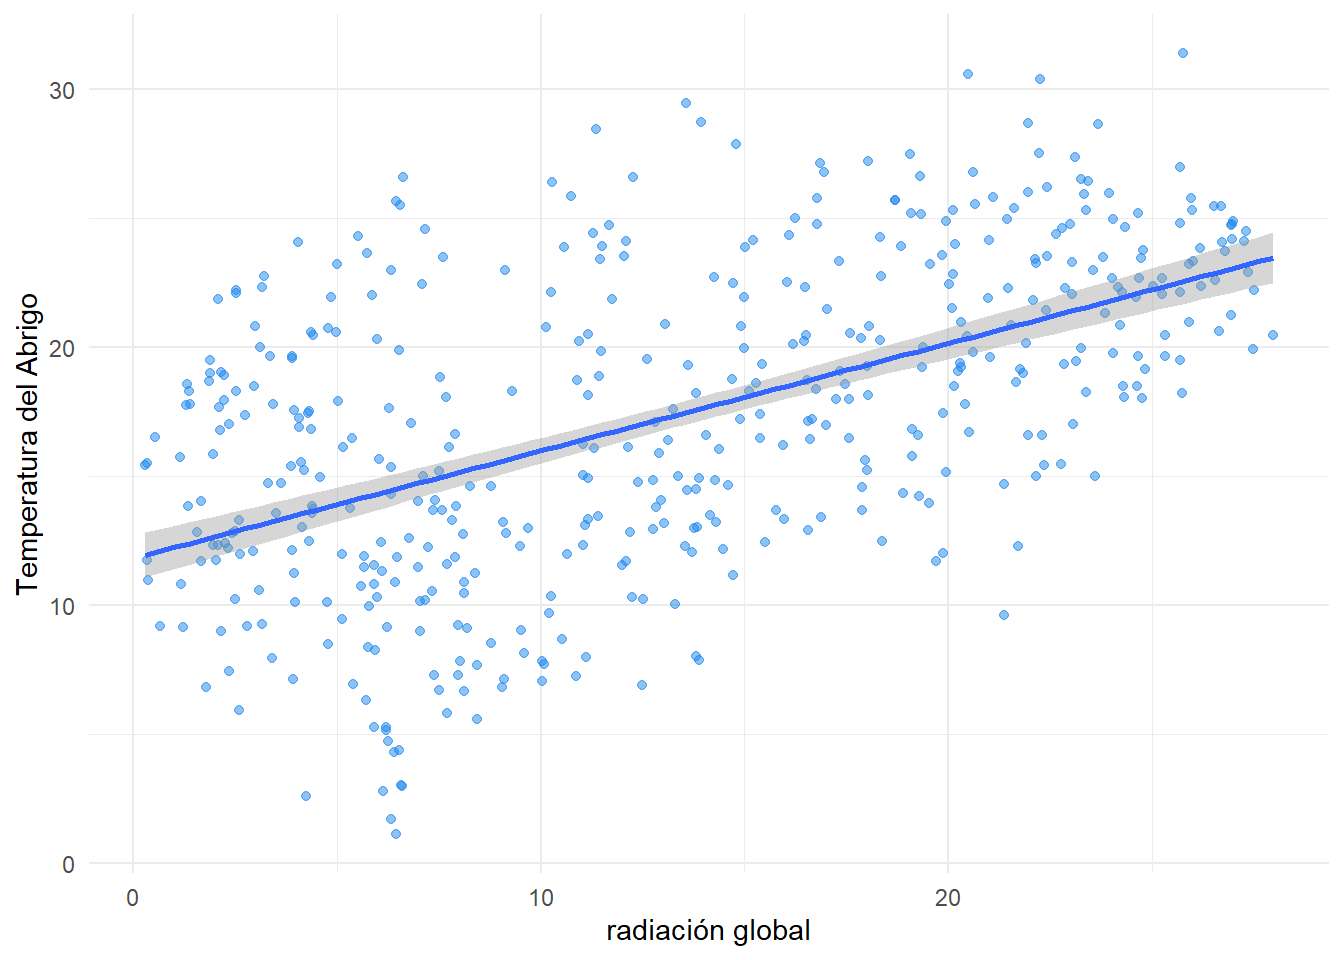

In [ ]:
ggplot(df, aes(x = Radiacion_Global, y = Temperatura_Abrigo_150cm)) +
  geom_point(alpha = 0.5,
             color = "dodgerblue2") +
  geom_smooth(method = "lm", 
              se = TRUE) + 
  labs(x = "radiación global",
       y = "Temperatura del Abrigo") +
  theme_minimal()

Antes de empezar con el modelo, vamos a testear los supuestos de independencia y distribución de los que partimos para obtener sus correspondientes valores:

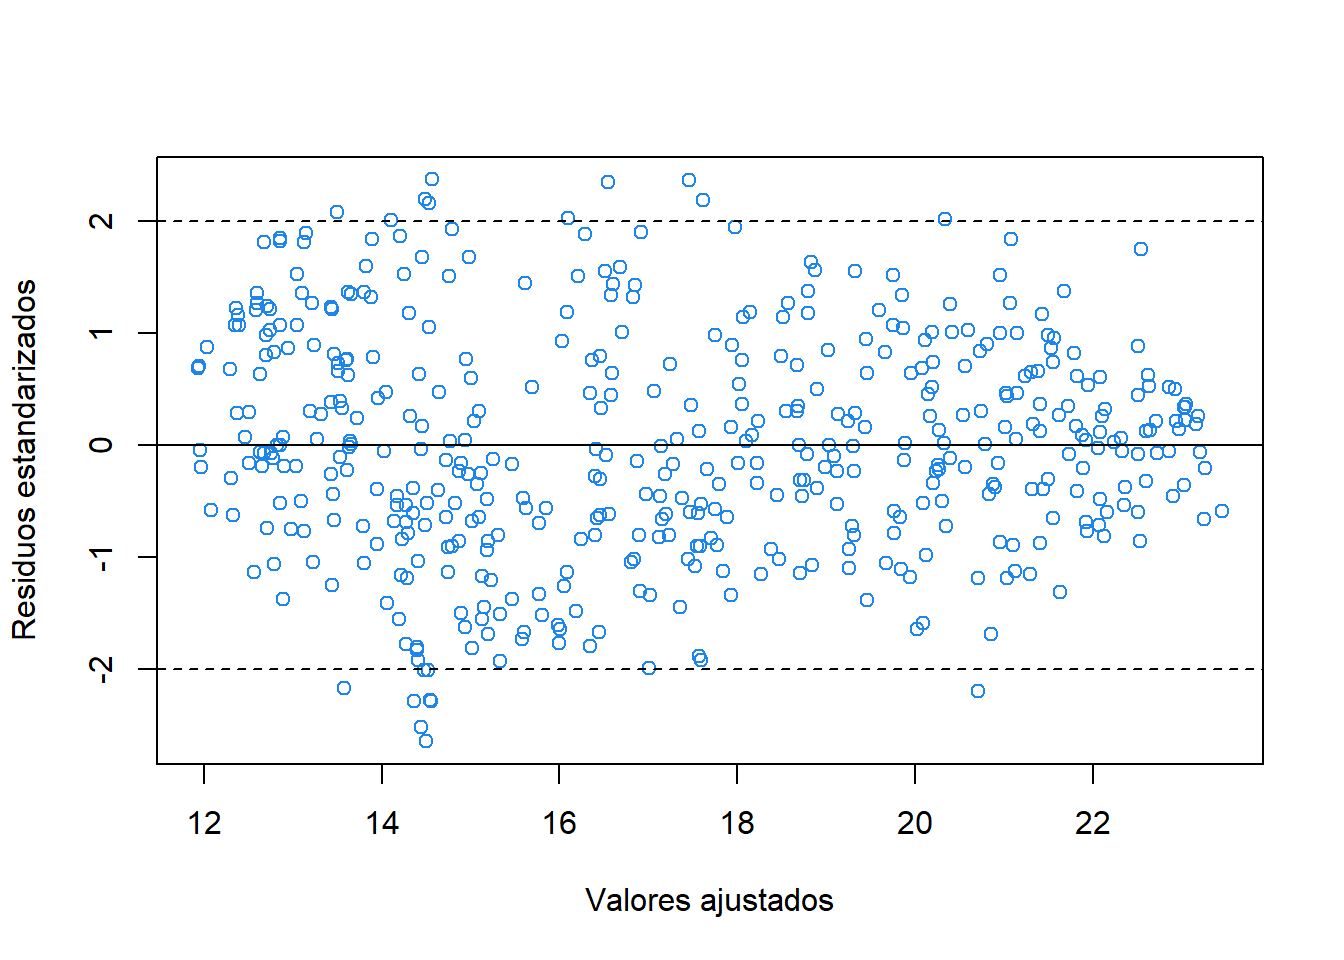

In [ ]:
# Residuos estandarizados vs Valores ajustados

plot(fitted(modelo_regresion),
     rstandard(modelo_regresion),
     col = "dodgerblue2",
     xlab = "Valores ajustados",
     ylab = "Residuos estandarizados")
abline(h=2, lty=2, lwd=1, col="black")
abline(h=-2, lty=2, lwd=1, col="black")
abline(h=0, col="black")

En este gráfico, vamos a observar la relación entre los valores ajustados y el residuo estandarizado. Podemos ver, así, que existen algunos valores atípicos que se ubican por fuera del rango (-2,2).

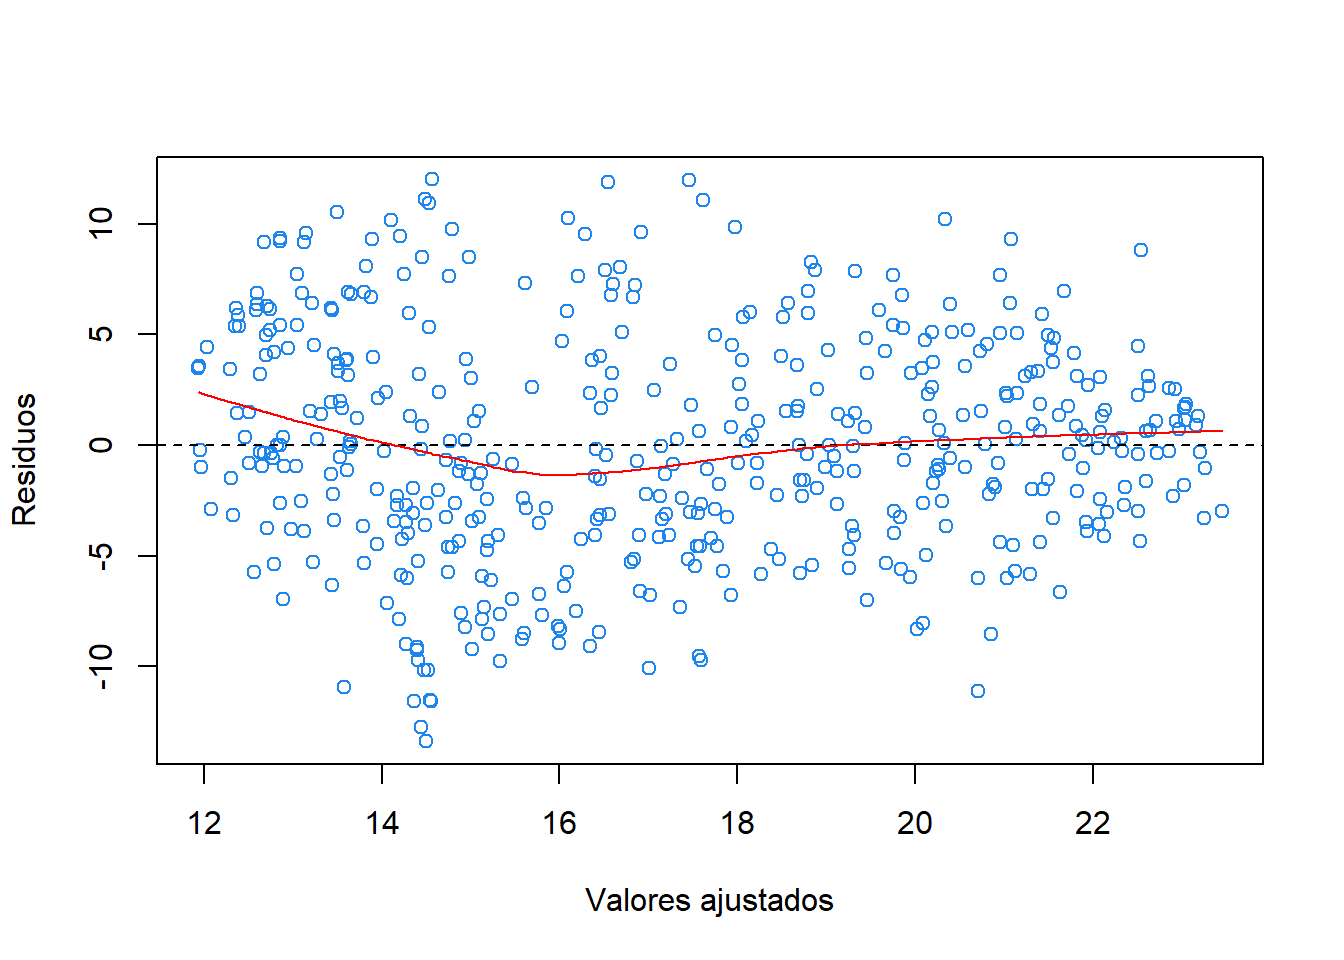

In [ ]:
# Residuos vs Valores ajustados

plot(fitted(modelo_regresion),
     resid(modelo_regresion),
     col = "dodgerblue2",
     xlab = "Valores ajustados",
     ylab = "Residuos")
abline(h = 0, lty = 2, col = "black") 
lines(lowess(fitted(modelo_regresion), 
             resid(modelo_regresion)), 
      col = "red")  

En relación al comportamiento de la varianza σ², veremos que la curva roja (útil para verificar la media cero) es relativamente plana y cercana a cero.

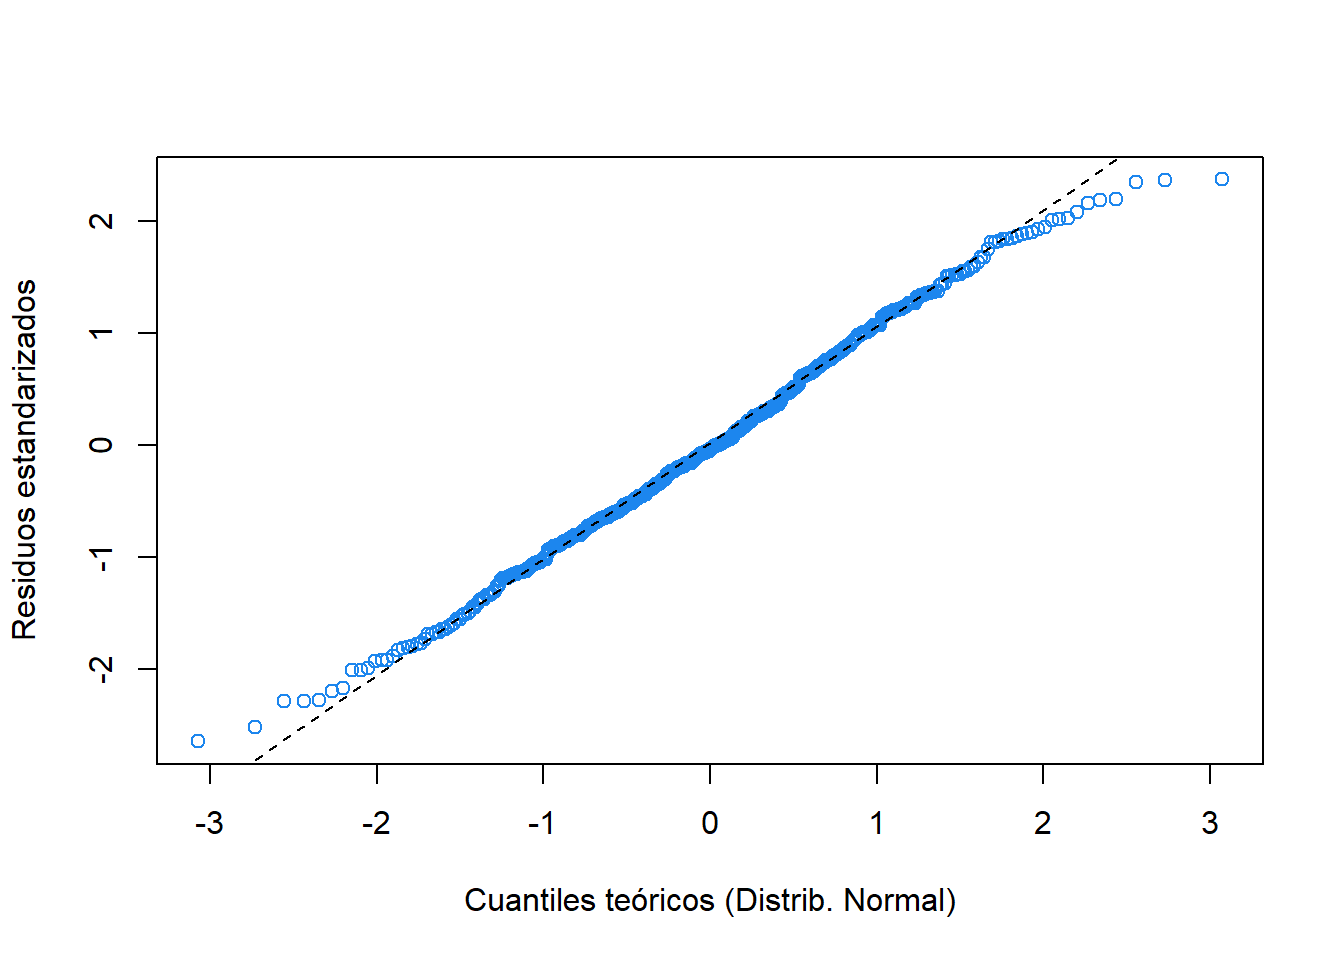

In [ ]:
# Gráfico Q-Q de normalidad

qqnorm(
  rstandard(modelo_regresion),
  col = "dodgerblue2",
  main = "",
  xlab = "Cuantiles teóricos (Distrib. Normal)",  
  ylab = "Residuos estandarizados"       
)
qqline(rstandard(modelo_regresion), col = "black", lty = 2)  

Finalmente, la curva de QQ-Plot nos permite observar que, con la información y evidencia disponible, la condición de normalidad ajusta bien, tomando apenas una forma de S en las puntas.

In [ ]:
summary(modelo_regresion)


Call:
lm(formula = Temperatura_Abrigo_150cm ~ Radiacion_Global, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.3965  -3.4291  -0.2018   3.6603  12.0112 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      11.81568    0.45364   26.05   <2e-16 ***
Radiacion_Global  0.41605    0.02961   14.05   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.067 on 470 degrees of freedom
Multiple R-squared:  0.2958,    Adjusted R-squared:  0.2943 
F-statistic: 197.5 on 1 and 470 DF,  p-value: < 2.2e-16

De esta manera, no habiendo evidencia suficiente para rechazar las condiciones para el ruido aditivo E ∼ N(0, σ²), podemos considerar ambas variables X e Y como aleatorias y definir su coeficiente de correlación. Tal como vimos en el resumen del modelo:

In [ ]:
# Coeficiente de determinación (R-cuadrado)
print("Coeficiente de correlación (R²):")

[1] "Coeficiente de correlación (R²):"

[1] 0.2958

Este coeficiente expresa cuánto de la variabilidad de los datos es explicada por el modelo de regresión lineal y su bajo valor nos hace dudar acerca de la representatividad del modelo que desarrollamos.

Aún así, verificamos que el p-valor de la pendiente ß₁ y de la ordenada al origen ß₀ son muy pequeños, lo que puede significar que exista una relación lineal entre ambas variables o que con un polinomio de mayor orden se obtenga un mejor resultado. Entonces, bajo la condición de normalidad, podremos realizar un test de hipótesis sobre la pendiente:

-   *H₀: ß₁ = 0*

-   *H₁: ß₁ ≠ 0*

In [ ]:
resumen <- summary(modelo_regresion)
coef_info <- resumen$coefficients["Radiacion_Global", ]

cat("Estadísticos:\n",
    "Coeficiente estimado:", round(coef_info["Estimate"], 2), "\n",
    "Error estándar:", round(coef_info["Std. Error"], 2), "\n",
    "Estadístico t:", round(coef_info["t value"], 2), "\n",
    "Grados libertad:", nrow(modelo_regresion$model) - 2, "\n",
    "p-valor:", format.pval(coef_info["Pr(>|t|)"]), "\n\n")

Estadísticos:
 Coeficiente estimado: 0.42 
 Error estándar: 0.03 
 Estadístico t: 14.05 
 Grados libertad: 470 
 p-valor: < 2.22e-16 

Como el p-valor es menor a un nivel de significatividad α del 5%, podemos comprobar que no existe evidencia suficiente para descartar la relación lineal entre las variables.

Así, tal como fue planteado anteriormente, vamos a realizar una regresión lineal múltiple incorporando el resto de las variables con las que contamos. En este caso, a diferencia de la regresión previa, tomaremos la Radiación Global como variable dependiente.

In [ ]:
modelo_regmult <- lm(Radiacion_Global ~ Temperatura_Abrigo_150cm + Humedad_Media + Presion_Media, data = df)

summary(modelo_regmult)


Call:
lm(formula = Radiacion_Global ~ Temperatura_Abrigo_150cm + Humedad_Media + 
    Presion_Media, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.8268  -2.6337   0.0715   2.9446  15.1407 

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)              -219.47802   45.34368  -4.840 1.76e-06 ***
Temperatura_Abrigo_150cm    0.64788    0.04723  13.718  < 2e-16 ***
Humedad_Media              -0.36862    0.01787 -20.624  < 2e-16 ***
Presion_Media               0.24583    0.04368   5.628 3.15e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 4.387 on 468 degrees of freedom
Multiple R-squared:  0.6925,    Adjusted R-squared:  0.6905 
F-statistic: 351.3 on 3 and 468 DF,  p-value: < 2.2e-16

Podremos ver así que el R² será signficativamente mayor, explicando casi el 70% de la variabilidad de los datos, y el R² ajustado no será mucho menor al haber incorporado más variables al modelo. Cabe señalar que, en el caso de los coeficientes, el t-valor de la presión media es mayor que los demás, lo que podría cuestionarnos acerca de la significancia estadística que suma al modelo su incorporación.

## 3. Estadística no paramétrica


=== MÉTODO PARAMÉTRICO (REGRESIÓN LINEAL) ===

Coeficiente: 0.4161 
Valor-p: < 2.2e-16 


=== MÉTODO NO PARAMÉTRICO (SPEARMAN) ===

Coeficiente Rho: 0.54 
Valor-p: < 2.2e-16 

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'

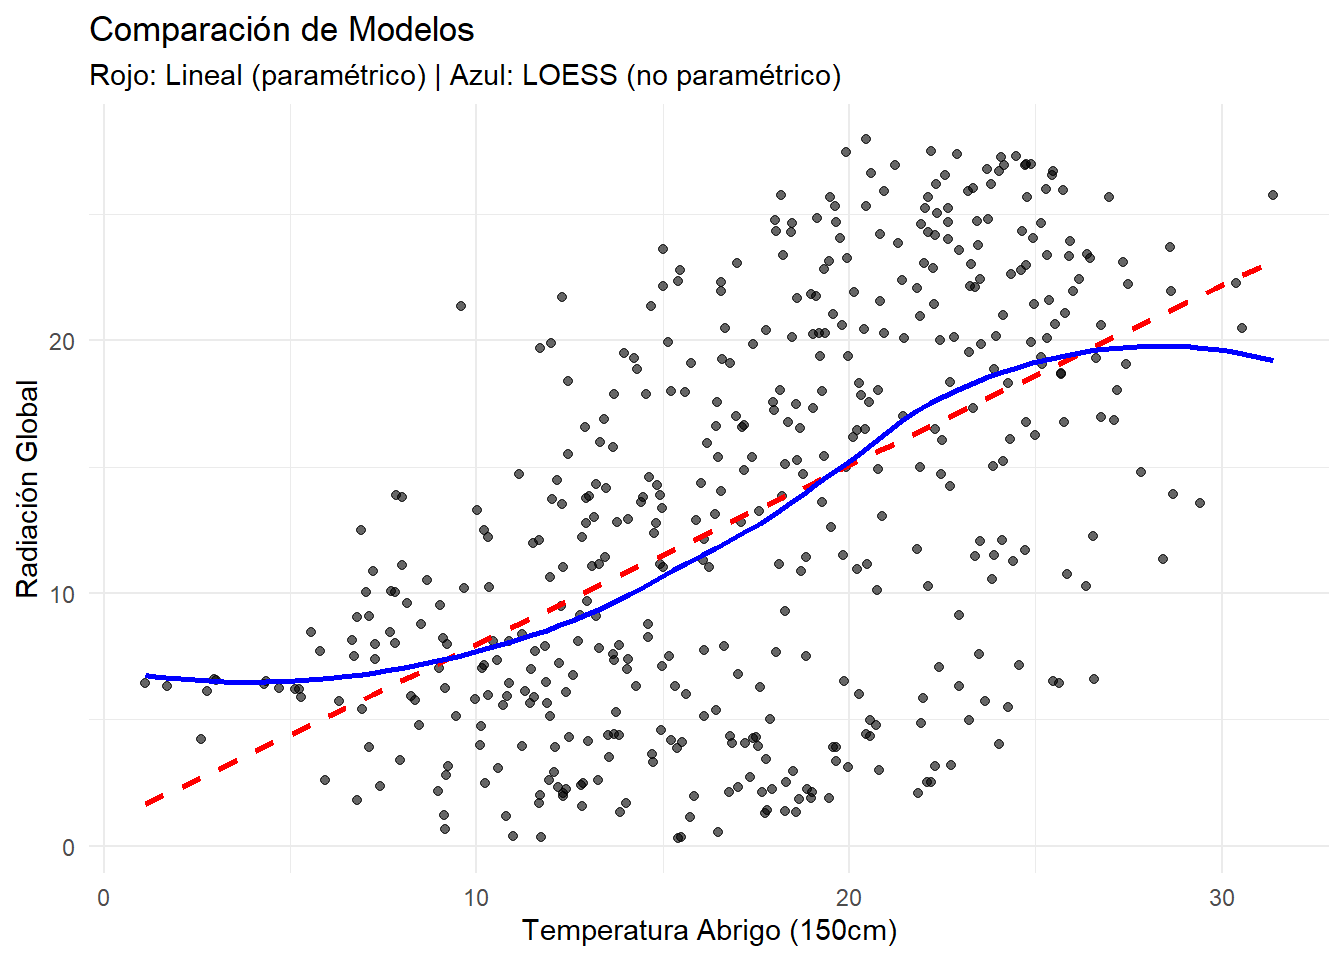


=== CONCLUSIÓN COMPARATIVA ===

Ambos métodos coinciden en que existe relación significativa (p < 0.05).
El modelo paramétrico estima una pendiente de 0.4161 mientras que Spearman muestra una correlación de 0.54 

In [ ]:
# Test Paramétrico Original (Regresión Lineal)
cat("\n=== MÉTODO PARAMÉTRICO (REGRESIÓN LINEAL) ===\n")